### Graph Hot Spots Conjecture: Experiments
Arya Maheshwari

Testing graph hot spots conjecture on different examples of graphs and to come up with possible conditions for which conjecture could hold (combinations of planarity, convexity, etc) 

In [59]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#### 1. Generate graphs
<font color='purple'> Key part of project: </font> Testing wide variety of graphs, algorithmically/programmatically <font color='red'> (TBD) </font>
<br> - checking convexity examples (convex, strictly convex)
<br> - checking planarity examples

In [116]:
# generate some test graph for now

# G = nx.random_powerlaw_tree(15)
G = nx.grid_2d_graph(5, 10)

node_list = list(G.nodes)

G.nodes

NodeView(((0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9)))

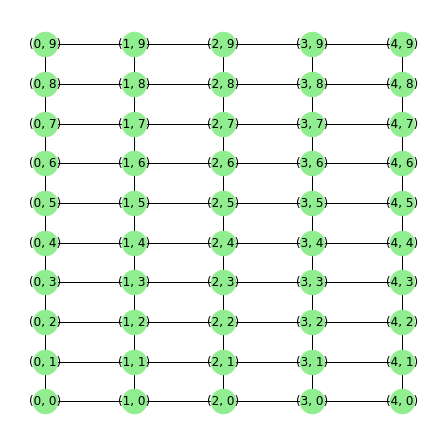

In [101]:
# FOR GRID GRAPH
plt.figure(figsize=(6,6))

pos = {(x,y):(x,y) for x,y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=600)

#### 2. Compute second-smallest eigenfunction $\phi_2$
Directly from networkx fielder_vector method

In [102]:
phi2 = nx.fiedler_vector(G)
phi2

array([-0.19753767, -0.17820131, -0.14142136, -0.0907981 , -0.03128689,
        0.0312869 ,  0.09079811,  0.14142136,  0.17820131,  0.19753767,
       -0.19753767, -0.17820131, -0.14142136, -0.0907981 , -0.03128689,
        0.0312869 ,  0.0907981 ,  0.14142136,  0.1782013 ,  0.19753767,
       -0.19753767, -0.17820131, -0.14142136, -0.0907981 , -0.03128689,
        0.0312869 ,  0.0907981 ,  0.14142136,  0.1782013 ,  0.19753766,
       -0.19753767, -0.17820131, -0.14142136, -0.0907981 , -0.03128689,
        0.0312869 ,  0.0907981 ,  0.14142135,  0.1782013 ,  0.19753766,
       -0.19753767, -0.17820131, -0.14142136, -0.0907981 , -0.03128689,
        0.0312869 ,  0.0907981 ,  0.14142135,  0.1782013 ,  0.19753766])

#### 3. Compute boundary of graph
Brute-force algorithm based on $\partial G$ as defined in https://arxiv.org/pdf/2201.03489.pdf:

In [103]:
def boundary(G):
    '''
    Returns list of nodes in G that are in the boundary.
    '''
    # compute shortest path lengths between all vertices
    path_dist = dict(nx.all_pairs_shortest_path_length(G))

    boundary = []
    for u in list(G.nodes): 
        for v in list(G.nodes): # test all v for witness of u as boundary vertex
            dsum = 0
            for w in G.neighbors(u):
                dsum += path_dist[w][v] # compute sum of distances from v to neighbors of u (= w)
            if(path_dist[u][v] > dsum/len(G[u])):
                boundary.append(u)
                break # move on to next vertex to test for boundary
    
    return boundary

In [104]:
boundary = boundary(G)
bound_set = set(boundary)

#### 4. Check conjecture: are smallest and largest values on boundary?

In [118]:
min_node = node_list[list(phi2).index(min(phi2))]
max_node = node_list[list(phi2).index(max(phi2))]

print("Maximum node in Fiedler vector:",max_node)
print("On boundary?", (max_node in bound_set))
print("Minimum node in Fiedler vector:",min_node)
print("On boundary?", (min_node in bound_set))


Maximum node in Fiedler vector: (0, 9)
On boundary? True
Minimum node in Fiedler vector: (4, 0)
On boundary? True


---

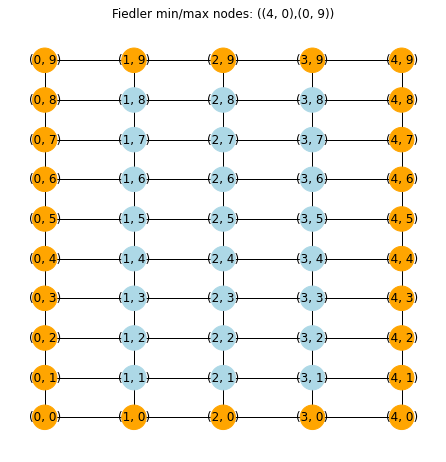

In [120]:
# visualize obtained boundary in graph drawing
plt.figure(figsize=(6,6))
colors = ['orange' if n in bound_set else 'lightblue' for n in list(G.nodes)]
pos = {(x,y):(x,y) for x,y in G.nodes()}

nx.draw(G, node_color=colors, pos=pos, with_labels=True, node_size=600)

plt.title("Fiedler min/max nodes: ("+str(min_node)+","+str(max_node)+")")
plt.show()